In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import heapq
import shap
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from xgboost import XGBClassifier
from sklearn.multioutput import ClassifierChain

shap.initjs()

# Data
Our dataset consists of RSSI measurements in 12 squares 1m x 1m.

We can visualize the squares placing nextly:

<pre>
1---|----|----+  
| 0 | 1  | 2  |  
| 3 | 4  | 5  |  
| 6 | 7  | 8  |   
| 9 | 10 | 11 |
2---|----|----3
</pre>

Numbers at the corners are the numbers of beacon and their locations

In each square we collected records for 5 points (200 
records for each point).

In [2]:
dfRaw = pd.read_csv("data/fingerprinting.csv",index_col=["Unnamed: 0"])

Preview of our dataset

In [3]:
dfRaw.head()

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Square,Point
0,-70,-49,-62,s8,0
1,-62,-46,-59,s8,0
2,-62,-46,-59,s8,0
3,-62,-46,-58,s8,0
4,-62,-46,-58,s8,0


General statistics about data 

In [4]:
dfRaw.describe()

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Point
count,12000.000000,12000.000000,12000.000000,12000.000000
mean,-63.047083,-56.039917,-60.655917,2.000000
std,6.926979,7.133307,6.059435,1.414272
min,-87.000000,-89.000000,-88.000000,0.000000
25%,-67.000000,-60.000000,-65.000000,1.000000
50%,-63.000000,-56.000000,-60.000000,2.000000
75%,-57.000000,-51.000000,-57.000000,3.000000
max,-52.000000,-39.000000,-47.000000,4.000000


# Preprocessing

- We need to get rid of column Point since we dont have it on real data.
- We need our target variable (__Square__) to be numeric for the classification.
- We add 95 to all RSSI values to make them non-negative. It is important for Bayesian classification.

From preprocessed data we form additional dataset for **multilabel** classification.  
Target variable is [__*x*__ ,__*y*__], x- number 
of row and y - number of cell in this row.

In [4]:
dfRaw.drop(["Point"],axis=1,inplace=True)
dfRaw["Square"]= dfRaw["Square"].apply(lambda x:int(x[1:]))
dfRaw["Server-RSSI-1"]=dfRaw["Server-RSSI-1"].apply(lambda x:x+95)
dfRaw["Server-RSSI-2"]=dfRaw["Server-RSSI-2"].apply(lambda x:x+95)
dfRaw["Server-RSSI-3"]=dfRaw["Server-RSSI-3"].apply(lambda x:x+95)

multiDf=dfRaw.copy()
multiDf["y"] = multiDf["Square"] // 4
multiDf["x"] = multiDf["Square"] % 4
multiDf.drop(["Square"],axis=1, inplace=True)

Helper functions, just to make our life a little bit easier and code more readable. :=)

In [5]:
def get_trained_with_hyperparams(model,params,X_train,Y_train):
    gsrch = GridSearchCV(estimator = model(),param_grid=params,scoring="accuracy",cv=5,n_jobs=-1).fit(X_train,Y_train)
    return model(**gsrch.best_params_).fit(X_train,Y_train)

def show_scores(model,X_test,Y_test):
    predicted = model.predict(X_test)
    print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (Y_test != predicted).sum()))
    probabilities = model.predict_proba(X_test)
    selected = []
    for i in probabilities:
        d = dict()
        for x,y in enumerate(i):
            d[x]=y
        selected.append(d)
    topFive = [heapq.nlargest(5,d,key=d.get)for d in selected]
    failed = 0
    for x,y in enumerate(topFive):
        if Y_test.iloc[x] not in y:
            failed+=1
    print("Number of points not in top 5 predicted probabilities total points: %d; failed: %d"% (X_test.shape[0], failed))

# Classifiers
In this section we are using classification approaches on our "raw" data (our target variable will be square's number) 
without any additional filtering or other approaches...  For visualisation we use __*SHAP library*__, which is based 
on game theory. It will help us to explain the results and importance of each beacon.

## Bayesian classification
We start with it since it`s results are easy for explanation.

Multinomial Naive Bayes model is used because our data is discrete and non-binary.

Number of mislabeled points out of a total 2400 points : 1720
Number of points not in top 5 predicted probabilities total points: 2400; failed: 652


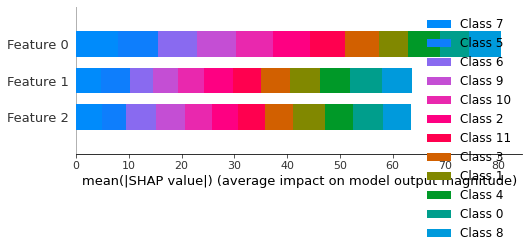

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(dfRaw.drop(["Square"],axis=1), dfRaw["Square"], test_size=0.2, random_state=42,stratify=dfRaw["Square"])

model_nb = MultinomialNB().fit(X_train,Y_train)
show_scores(model_nb,X_test,Y_test)

explainer= shap.LinearExplainer(model_nb,X_train)
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.to_numpy() # we need to pass a dense version for the plotting functions
#TODO: make shap more readable and explain a little more them :=)
shap.summary_plot(shap_values, X_test_array)

Using Bayesian model, we can see $P(X | C_i)$, where $C_i$ is the number of the square. From likelihood we can conclude, 
that it is high probability, that our data cannot be explained by this model, because we observe low probability, that
our prediction is correct.

In [27]:
np.exp(np.apply_along_axis(sum, 1, model_nb.feature_log_prob_))

array([0.03652242, 0.0361251 , 0.03649252, 0.03682964, 0.03701261,
       0.03532847, 0.03448015, 0.03468364, 0.03697773, 0.03543772,
       0.03603909, 0.03679036])

## Logistic model
Another approach is __*Logistic model classification*__. It is not expected to perform extremely accurately, since our
target column (squares) *are not linear* (square with index 3 is farm from square with index 2). Good idea here is to
try different hyper parameters to increase accuracy. Also another problem is with RSSI, that it hasn't linear 
correlation with distance to square. One idea to use next formula:

$RSSI = 10\log_{10} \frac{P}{1mW}$

to get power, and then knowing inverse-square law find data the linearly corresponds to distance. But we have 
problem, that we **each chip manufacturer computes RSSI in different ways** and also, that if we will
take exponenent of RSSI/10 it will be nearly sixth digits after the point (mean value of RSSI, as shown above is nearly
-60), so **floating-point errors** will make much more trouble.

### Correlation matrix
We can easily observe that our data is not linear, by looking correlation (x,y, square number) with RSSI values
from different beacons

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Correlation of RSSI values from different beacons to Square')

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Corrleation of RSSI values from different beacons to x')

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Corrleation of RSSI values from different beacons to y')

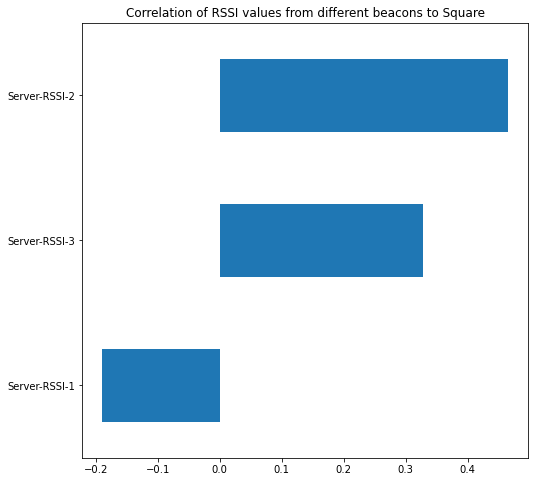

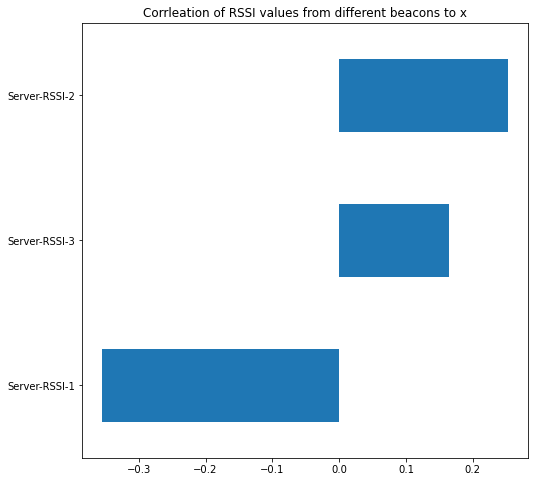

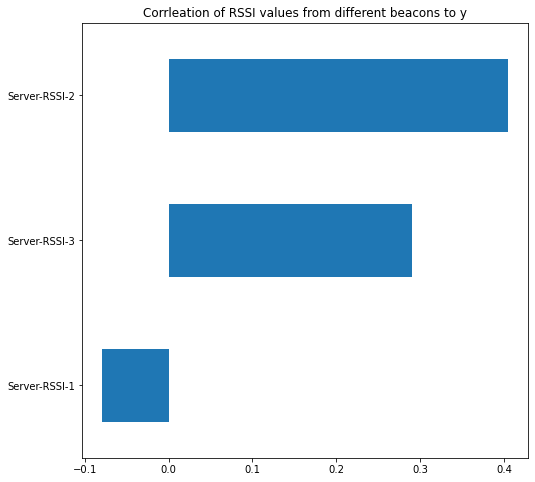

In [7]:
corr = dfRaw.corr()
plt.figure(figsize=(8,8))
corr["Square"].sort_values(ascending=True)[:-1].plot(kind="barh")
plt.title("Correlation of RSSI values from different beacons to Square")

corr_x = multiDf.drop(columns=["y"]).corr()
plt.figure(figsize=(8,8))
corr_x["x"].sort_values(ascending=True)[:-1].plot(kind="barh")
plt.title("Corrleation of RSSI values from different beacons to x")

corr_x = multiDf.drop(columns=["x"]).corr()
plt.figure(figsize=(8,8))
corr_x["y"].sort_values(ascending=True)[:-1].plot(kind="barh")
plt.title("Corrleation of RSSI values from different beacons to y")

From next correlation matrix, we can see, that RSSI values from 1 and 3 beacon has significant level of
correlation. It caused by their location in opposite corners.

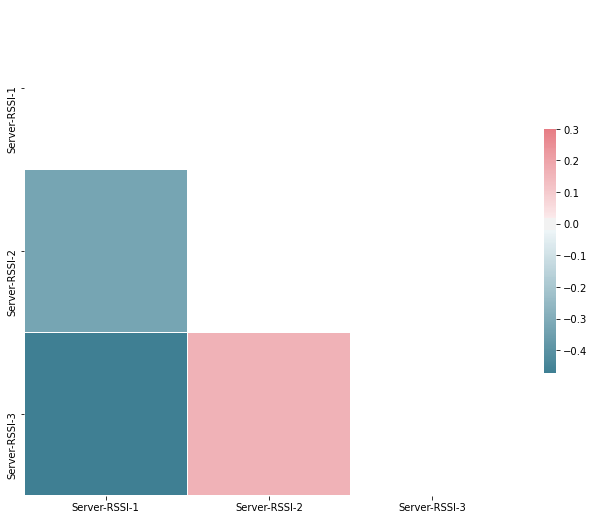

In [9]:
corr = dfRaw.drop(columns=["Square"]).corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [7]:
# LONG RUNNING CELL
#TODO: Remove grid search with params
hyper_params = {"C":[3],
                "class_weight":[None,"balanced"],
                "intercept_scaling":[1,2,3,4],
                "solver":["newton-cg", "lbfgs",  "sag", "saga"],
                "max_iter":[1500],
                "random_state":[42]
               }

model = get_trained_with_hyperparams(LogisticRegression,hyper_params,X_train,Y_train)

In [8]:
show_scores(model,X_test,Y_test)
explainer= shap.LinearExplainer(model,X_train)
#TODO: visualize with shap

## Support Vector Machine Classifier

SVM in comparison with Logistic Regression can deal with non-linearity of our data by using different kernels.
Also comparing with logistic regression, it will find decision boundary with biggest margin, so it will
be more robustness on the data, that model haven't seen yet.

In [22]:
# TODO: Write more detail on SVC kernel
model_svc = SVC(random_state=42, C=15)
classifier = CalibratedClassifierCV(model_svc).fit(X_train,Y_train)
show_scores(classifier,X_test,Y_test)

Number of mislabeled points out of a total 2400 points : 80
Number of points not in top 5 predicted probabilities total points: 2400; failed: 7


## Random Forest Classifier
Random Forest is based on Decision trees, so it can easily handle with non-linear data. But as Random Forest
randomly choose features for different trees, so it can deal with overfitting for decision trees.

In [30]:
model_rfc = RandomForestClassifier(random_state=42, max_depth=10).fit(X_train,Y_train)
show_scores(model_rfc,X_test,Y_test)

Number of mislabeled points out of a total 2400 points : 62
Number of points not in top 5 predicted probabilities total points: 2400; failed: 6


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


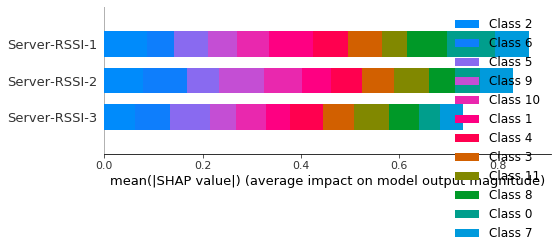

In [9]:
explainer = shap.TreeExplainer(model_rfc)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [10]:
print("Importance of corresponding RSSI beacons: %.2f, %.2f, %.2f" % (model_rfc.feature_importances_[0], 
                                                                      model_rfc.feature_importances_[1], 
                                                                      model_rfc.feature_importances_[2]))

Importance of corresponding RSSI beacons: 0.34, 0.31, 0.36


We can see, that our positions for beacons are not optimal, as corresponding feature's importance are not equal.
Also we can see, that second beacon has the smallest importance. We can easily it explain, as beacons were placed in the
corners of the right triangle, but data was gathered from the rectangle zone. So the beacons, that were not on right
angle were giving much more info.

## XGBoost
XGBoost is similar to RandomForest, but it uses boosting ensemble in opposed to bagging. So it is 
no shock, that they have similar results.

In [ ]:
model_xgb = XGBClassifier(random_state=42, max_depth=10).fit(X_train, Y_train)

show_scores(model_xgb, X_test, Y_test)

We can see, that for XGBoost classifier beacon's were as well not important. But, comparing with RandomForest features
importance, second and third have equal importance. We can intepretet it in such way, that first beacon was mainly used
to classify squares in top right part of rectangle (squares 3, 6, 7)

In [ ]:
print("Importance of corresponding RSSI beacons: %.2f, %.2f, %.2f" % (model_xgb.feature_importances_[0], 
                                                                      model_xgb.feature_importances_[1], 
                                                                      model_xgb.feature_importances_[2]))

# Multi label classification
Before we treated our result as single multiclass classification, but we know, that actually it is number of square
on the floor. It is better to divide our problem into two: x and y coordinate of square in our grid. In that case our 
target variables will be linear (because in our grid square 0 has the same distance to square 4 and square 1), so it 
will improve some models.

But in that case we are moved from multiclass to multilabel, we cannot simply use classification models.
To deal with multilabel part of problem are next solutions:
- Binary Relevance (just use classic classification model for each label)
  - Con: Doesn't take into account some correlation between labels
- Label Powerset (transforms to multiclass problem by taking Cartesian product of classes in each label)
  - Con: we moved from multiclass to multilabel and it will be just step back )
- Classifier Chain (one classiciation model for each label, but for each next label, classificator also takes as input
result of previous classification)
   - Perfect for us

## Classifier chain

In [4]:
X_multitrain, X_multitest, y_multitrain, y_multitest = train_test_split(multiDf.drop(["x", "y"],axis=1), 
                                                                        multiDf[["x", "y"]], 
                                                                        test_size=0.2, 
                                                                        random_state=42,
                                                                        stratify=multiDf[["x", "y"]])

In [10]:
def show_classifier_chain_error(model):
    chain_model = ClassifierChain(
        base_estimator=model,
        order=[0,1],
        random_state=42,
    ).fit(X_multitrain, y_multitrain)

    predicted = chain_model.predict(X_multitest)
    print("Number of mislabeled points out of a total %d points : %d" % 
          (X_multitest.shape[0], len(predicted) - sum([list(y_multitest["x"] == predicted[:, 0])[i] and list(y_multitest["y"] == predicted[:, 1])[i] for i in range(len(predicted))])))
    return chain_model

### XGBoost

We can see, transforming our problem to multilabel helped to improve accuracy. But more importantly, we 
can look on the feature importance of and see __*0*__ and __*1*__  beacons are mostly used to predict
y coordiante. So our model is just calculating how far point is from __*01*__ line formed by two beacos.
But for x coordinate all the beacons are nearly equal, except for a little more importance on __*1*__ beacon.

In [12]:
model_chain_xgb = show_classifier_chain_error(XGBClassifier(random_state=42))


print("Importance of corresponding RSSI beacons for x coordinate: %.2f, %.2f, %.2f" % (model_chain_xgb.estimators_[0].feature_importances_[0],
                                                                      model_chain_xgb.estimators_[0].feature_importances_[1], 
                                                                      model_chain_xgb.estimators_[0].feature_importances_[2]))

print("Importance of corresponding RSSI beacons for y coordinate: %.2f, %.2f, %.2f" % (model_chain_xgb.estimators_[1].feature_importances_[0],
                                                                      model_chain_xgb.estimators_[1].feature_importances_[1], 
                                                                      model_chain_xgb.estimators_[1].feature_importances_[2]))

Number of mislabeled points out of a total 2400 points : 52
Importance of corresponding RSSI beacons for x coordinate: 0.32, 0.35, 0.32
Importance of corresponding RSSI beacons for y coordinate: 0.29, 0.28, 0.19


# Summary
__*Since we reached such high accuracy, we finished the project and now gonna be rich LOL*__


